In [2]:
# auto reload changes ipynb
# auto reload
%load_ext autoreload
%autoreload 2
import sys

sys.path.append("/home/calvin/code/cmpnn_revised")

# Import Packages


In [3]:
from typing import List
from cmpnn.featurizer.molecule_dataset import MultiMoleculeSDFDataset
from cmpnn.standardisation.mix_target_normalizer import MixedTargetNormalizer, BaseNormalizer, LogNormalizer, PeriodicNormalizer
from cmpnn.featurizer.atom_bond import AtomFeaturizer, BondFeaturizer
from cmpnn.featurizer.global_feat import CompositeGlobalFeaturizer, MorganBinaryFeaturizer, RDKit2DNormalizedFeaturizer
from cmpnn.split.kennardstone import KennardStoneSplitter
from torch.utils.data import DataLoader
from cmpnn.data.collate import multimol_collate_fn
from cmpnn.models.lightning import MultiCMPNNLightningModule
from cmpnn.optimizer.noam import NoamLikeOptimizer
from cmpnn.data.target import TargetSpec
from cmpnn.standardisation.electromap_normalizer import ElectromapNormalizer
import torch
import torchmetrics
import pytorch_lightning as pl



# Define Required Variables for creating dataset

In [ ]:
sdf_files = "/home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/"
input_type = ["r1h", "r2h"]
target_data = "/home/calvin/code/chemprop_phd_customised/habnet/data/processed/target_data/target_data.csv"
target_columns = ["r1_radius","r2_radius","alpha_angle","psi_1_dihedral","psi_2_dihedral"]
target_kinds = ["continuous", "continuous", "continuous", "periodic", "periodic"] # Radius, Radius, Angle are continuous whilst Dihedral are periodic (0-360 degrees range -> convert to cosine/sine)

# Create Dataset

- sdf_files: can either be an '.sdf' or a folder that contains sdf's. In this SDF formate, there are three mols per file, with a type property ('r1h', 'r2h', 'ts'). Additionally, there is a property called 'reaction' that will help link them to the target data
- input_type: the types of the mols we are extracting from the SDF - order is important as it r1h will become 'donor' and 'r2h' will become 'acceptor'
- target_data: CSV file with the target data
- target_columns: the columns that are to be the target data. Supports more than one target.
- use_cache: boolean that can use the cached molecule dataset if continuously being called
- normalizer: the normalizing class to normalize the target data. MixedTargetNormalizer is for when there is a mixed type of target data and the kinds therefore need to be handled differently


> Note: When we do a periodic normalisation, we turn the 0-360 degree value into a two parts: cosine and sine. So if you had two target values, both periodic, then the resulting transformation would be 4 targets

In [5]:
normalizers = [
    BaseNormalizer(),
    BaseNormalizer(),
    BaseNormalizer(),
    # LogNormalizer(shift=129.21),
    PeriodicNormalizer(),
    PeriodicNormalizer()
]
normalizer = MixedTargetNormalizer(kinds=target_kinds,
                                   normalizers=normalizers)
atom_normalizer = ElectromapNormalizer()


m_dataset = MultiMoleculeSDFDataset(
    sdf_files=sdf_files,
    input_type=input_type,
    target_data=target_data,
    target_columns=target_columns,
    atom_featurizer=AtomFeaturizer(v2=False),
    bond_featurizer=BondFeaturizer(),
    use_cache=False,
    normalizer=normalizer,
    atom_feature_normalizer=atom_normalizer,
    use_electro_map=True
    )


Using all atomic numbers from 1 to 100
Processing and caching dataset to /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/sdf_folder_cache.pt
Target data for reaction 'rxn_288' not found in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rxn_288.sdf.
Target data for reaction 'rxn_635' not found in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rxn_635.sdf.
Target data for reaction 'rxn_785' not found in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rxn_785.sdf.


In [6]:
print("Number of molecules in dataset: ", len(m_dataset))

Number of molecules in dataset:  1807


In [7]:
# Check the first molecule pair
m_dataset[0]

[MoleculeData(f_atoms=[8, 144], f_bonds=[14, 158], a2b=[8], b2a=[14], a_scope=[1], b_scope=[1], y=[5], bonds=[7, 2], smiles='[H]OC(=C=O)C([H])=O', b2revb=[14], name='kfir_rxn_10218_r1h', comp_type='donor'),
 MoleculeData(f_atoms=[7, 144], f_bonds=[14, 158], a2b=[7], b2a=[14], a_scope=[1], b_scope=[1], y=[5], bonds=[7, 2], smiles='[H]C1([H])OC1([H])[H]', b2revb=[14], name='kfir_rxn_10218_r2h', comp_type='acceptor')]

In [8]:
# Check that the first molecule pair have marked heavy and hydrogen acceptors and donors
last_4_names = ["acceptor", "a_hydrogen", "donator", "d_hydrogen"]
l4_cols = m_dataset[0][0].f_atoms[:, 133:137].numpy()
# Print header
print("Molecule Type: ", m_dataset[0][0].comp_type)
print(' | '.join(f'{name:^10}' for name in last_4_names))
print('-' * 50)
for row in l4_cols:
    print(' | '.join(f'{val:10.3f}' for val in row))

l4_cols = m_dataset[0][1].f_atoms[:, 133:137].numpy()
# Print header
print("Molecule Type: ", m_dataset[0][1].comp_type)
print(' | '.join(f'{name:^10}' for name in last_4_names))
print('-' * 50)
for row in l4_cols:
    print(' | '.join(f'{val:10.3f}' for val in row))


Molecule Type:  donor
 acceptor  | a_hydrogen |  donator   | d_hydrogen
--------------------------------------------------
     0.000 |      0.000 |      1.000 |      0.000
     0.000 |      0.000 |      0.000 |      0.000
     0.000 |      0.000 |      0.000 |      0.000
     0.000 |      0.000 |      0.000 |      0.000
     0.000 |      0.000 |      0.000 |      0.000
     0.000 |      0.000 |      0.000 |      0.000
     0.000 |      0.000 |      0.000 |      0.000
     0.000 |      0.000 |      0.000 |      1.000
Molecule Type:  acceptor
 acceptor  | a_hydrogen |  donator   | d_hydrogen
--------------------------------------------------
     1.000 |      0.000 |      0.000 |      0.000
     0.000 |      0.000 |      0.000 |      0.000
     0.000 |      0.000 |      0.000 |      0.000
     0.000 |      1.000 |      0.000 |      0.000
     0.000 |      0.000 |      0.000 |      0.000
     0.000 |      0.000 |      0.000 |      0.000
     0.000 |      0.000 |      0.000 |      0.000


In [9]:
# Check that the first molecule pair have marked heavy and hydrogen acceptors and donors
last_4_names = ["R", "A", "Dsin", "Dcos", "has_R", "has_A", "has_D"]
l4_cols = m_dataset[0][0].f_atoms[:, -7:].numpy()
# Print header
print("Molecule Type: ", m_dataset[0][0].comp_type)
print(' | '.join(f'{name:^10}' for name in last_4_names))
print('-' * 50)
for row in l4_cols:
    print(' | '.join(f'{val:10.3f}' for val in row))

l4_cols = m_dataset[0][1].f_atoms[:, -7:].numpy()
# Print header
print("Molecule Type: ", m_dataset[0][1].comp_type)
print(' | '.join(f'{name:^10}' for name in last_4_names))
print('-' * 50)
for row in l4_cols:
    print(' | '.join(f'{val:10.3f}' for val in row))


Molecule Type:  donor
    R      |     A      |    Dsin    |    Dcos    |   has_R    |   has_A    |   has_D   
--------------------------------------------------
     0.800 |      0.000 |      0.000 |      1.000 |      1.000 |      0.000 |      0.000
     1.335 |    109.393 |      0.000 |      1.000 |      1.000 |      1.000 |      0.000
     1.348 |    120.822 |     -0.999 |     -0.040 |      1.000 |      1.000 |      1.000
     1.146 |    178.105 |      1.000 |     -0.014 |      1.000 |      1.000 |      1.000
     3.413 |     22.407 |      0.999 |      0.035 |      1.000 |      1.000 |      1.000
     1.206 |    163.758 |      0.206 |      0.979 |      1.000 |      1.000 |      1.000
     2.021 |     27.879 |      0.206 |     -0.978 |      1.000 |      1.000 |      1.000
     0.000 |      0.000 |      0.000 |      1.000 |      0.000 |      0.000 |      0.000
Molecule Type:  acceptor
    R      |     A      |    Dsin    |    Dcos    |   has_R    |   has_A    |   has_D   
------------

The above makes sense as each molecule should be with a combination of acceptor and a_hydrogen or donator and d_hydrogen

In [10]:
m_dataset[0][0]

MoleculeData(f_atoms=[8, 144], f_bonds=[14, 158], a2b=[8], b2a=[14], a_scope=[1], b_scope=[1], y=[5], bonds=[7, 2], smiles='[H]OC(=C=O)C([H])=O', b2revb=[14], name='kfir_rxn_10218_r1h', comp_type='donor')

In [11]:
# Check the first molecule pair's y values
# We also see that the the target dimensions are (1, 7) as the last two original targets were periodic and thus were converted to sine/cosine pairs
print("First molecule pair's y values: ", m_dataset[0][0]['y'])
print("First molecule pair's y values: ", m_dataset[0][1]['y'])

print("Y values are the same for both molecules: ", m_dataset[0][0]['y'] == m_dataset[0][1]['y'])

First molecule pair's y values:  tensor([  1.1457,   1.3843, 168.8217, 353.8592,   4.9276])
First molecule pair's y values:  tensor([  1.1457,   1.3843, 168.8217, 353.8592,   4.9276])
Y values are the same for both molecules:  tensor([True, True, True, True, True])


In [12]:
m_dataset.target_specs

[TargetSpec(name='r1_radius', kind='cont', slc=slice(0, 1, None), mu=None, std=None),
 TargetSpec(name='r2_radius', kind='cont', slc=slice(1, 2, None), mu=None, std=None),
 TargetSpec(name='alpha_angle', kind='angle', slc=slice(2, 3, None), mu=None, std=None),
 TargetSpec(name='psi_1_dihedral', kind='sincos', slc=slice(3, 4, None), mu=None, std=None),
 TargetSpec(name='psi_2_dihedral', kind='sincos', slc=slice(4, 5, None), mu=None, std=None)]

In [13]:
# We can also call the inverse transform method to get the original y values - We see that the shape is (1, 5) as the last two targets are periodic and have been inversely transformed back into the original dihedral angles
m_dataset.inverse_transform_y(inplace=False)[0] # inplace=False means we don't modify the y values in the dataset

RuntimeError: Cannot inverse transform: normalizer not fitted.

Original y values when we refer to the target data CSV

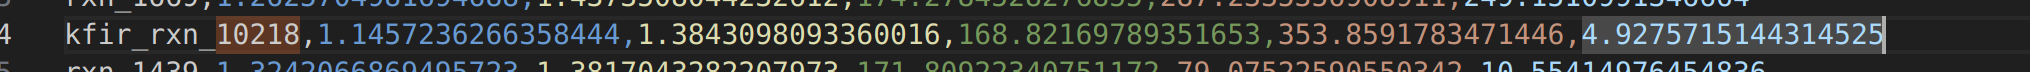

In [14]:
m_dataset[0][0]['y'], m_dataset[0][1]['y']

(tensor([  1.1457,   1.3843, 168.8217, 353.8592,   4.9276]),
 tensor([  1.1457,   1.3843, 168.8217, 353.8592,   4.9276]))

# Data Splitting - Kennard Stone Algorithm

The method begins by selecting two samples that are fartherest apart using geometric distance. Then, the algorithm adds another sample from the remaining ones that has the greatest separation from the already selected samples.  The separation distance of a candidate sample from the selected set is the distance from the candidate to its closest selected sample. This most separated sample is then added to the selection set and the process is repeated until the required number of samples, k, have been added to the selection set.

Ref: [Kennard Stone](https://www.wiki.eigenvector.com/index.php?title=Kennardstone)

 - `seed`: Random seed used for reproducibility when resolving ties or for future use with stochastic extensions (e.g., t-SNE in plotting).
 - `component`: Specifies which part of the molecular pair to use when calculating the distance matrix. Useful for isolating diversity based on one component or combining them.
    - 'donor' or 0: use only the donor molecule in each data pair for distance computation.
    - 'acceptor' or 1: use only the acceptor molecule.
    - 'joint': use both donor and acceptor components together.
- `distance_mode`: Determines how to merge donor and acceptor distances into a joint measure of pairwise similarity. This lets the user balance between equal weighting (mean), worst-case diversity (max), or full feature fusion (concat).
    - 'mean': average the donor and acceptor distance matrices.
    - 'max': take the element-wise maximum between donor and acceptor distances.
    - 'concat': concatenate donor and acceptor embeddings into a single vector and compute distances in that combined space.
- `distance_metric`: Specifies the distance metric used to calculate pairwise distances between molecule embeddings. Choice of metric can impact diversity selection in subtle ways.
    - Any metric supported by `sklearn.metrics.pairwise.pairwise_distances`

In [ ]:
splitter = KennardStoneSplitter(seed=42, component='joint', distance_mode='mean', distance_metric='euclidean')

In [16]:
train_ds, val_ds, test_ds, train_idx, val_idx, test_idx, order = splitter.split(
    dataset=m_dataset,
    train_frac=0.8,
    val_frac=0.1,
    test_frac=0.1,
    return_indices=True,
    return_order=True,
)

Distance matrix shape: (1807, 1807)
Distance matrix min/max: 0.0 471.3003
Distance matrix diagonal: [1.9073486e-06 0.0000000e+00 0.0000000e+00 2.6973983e-06 1.9073486e-06
 1.9073486e-06 1.3486991e-06 0.0000000e+00 2.3360155e-06 0.0000000e+00]


In [17]:
len(train_idx), len(val_idx), len(test_idx)
assert len(train_idx) == len(train_ds)
assert len(val_idx) == len(val_ds)
assert len(test_idx) == len(test_ds)

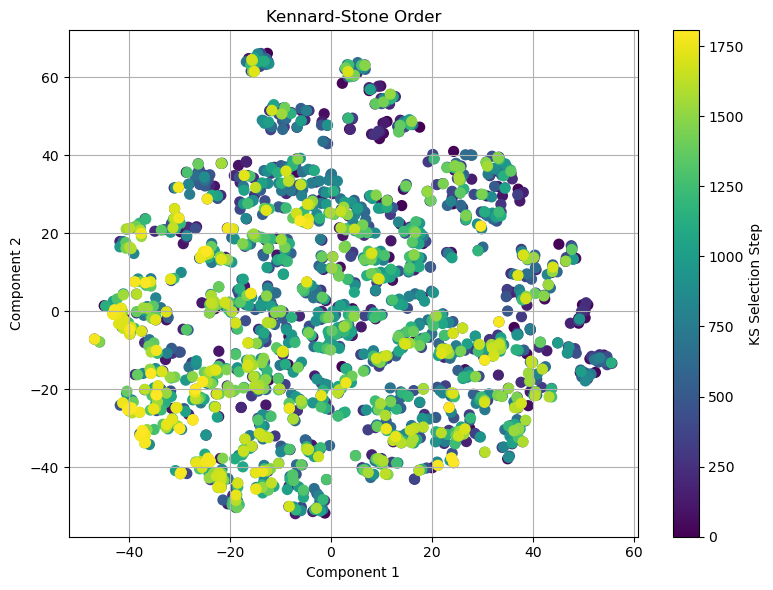

In [18]:
splitter.plot_distance_order(m_dataset, order, method="tsne")

🟣 dark = chosen early → more "diverse"

🟡 bright = chosen late → similar to what's already been picked

In [19]:
print("dataset fitted?", m_dataset.normalizer_fitted)
m_dataset.fit_normalizer_from_indices(train_idx)

# Apply to all splits
m_dataset.transform_y_from_indices(train_idx + val_idx + test_idx)
print("dataset fitted?", m_dataset.normalizer_fitted)

dataset fitted? False
dataset fitted? True


In [20]:
print(m_dataset[0][0].y)
print(m_dataset[0][1].y)

tensor([-1.6640, -0.0785, -0.9160, -0.1070,  0.9943,  0.0859,  0.9963])
tensor([-1.6640, -0.0785, -0.9160, -0.1070,  0.9943,  0.0859,  0.9963])


In [21]:
m_dataset.fit_atom_feature_normalizer_from_indices(train_idx)
m_dataset.transform_all_f_atoms()

In [22]:
train_ds[0][0].f_atoms[:, -7:]

tensor([[-0.5582,  0.6790,  0.0000,  1.0000,  1.0000,  1.0000,  0.0000],
        [-1.2587,  0.0000,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000],
        [-0.9632,  1.5977, -0.0403,  0.9992,  1.0000,  1.0000,  1.0000],
        [-0.2943, -1.2476, -0.8463, -0.5328,  1.0000,  1.0000,  1.0000],
        [-0.2955, -0.5728, -0.6161,  0.7877,  1.0000,  1.0000,  1.0000],
        [ 1.0387, -0.7154,  0.9377,  0.3476,  1.0000,  1.0000,  1.0000],
        [-0.2484, -0.7233,  0.0305, -0.9995,  1.0000,  1.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000]])

In [23]:
test_ds[0][0].f_atoms[:, -7:]

tensor([[ 0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000],
        [-0.2579,  0.5745,  0.9176,  0.3975,  1.0000,  1.0000,  1.0000],
        [-0.2374,  1.6594, -0.1475,  0.9891,  1.0000,  1.0000,  1.0000],
        [-0.5602,  0.7347,  0.0000,  1.0000,  1.0000,  1.0000,  0.0000],
        [-1.2587,  0.0000,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000],
        [-0.9695,  0.7631,  0.0831, -0.9965,  1.0000,  1.0000,  1.0000],
        [-0.2869, -1.2619, -0.8679, -0.4968,  1.0000,  1.0000,  1.0000],
        [-0.2756, -0.5786, -0.5837,  0.8120,  1.0000,  1.0000,  1.0000],
        [ 1.9770, -0.2156,  0.9521, -0.3059,  1.0000,  1.0000,  1.0000],
        [-0.3010, -0.7791,  0.5966,  0.8025,  1.0000,  1.0000,  1.0000],
        [ 1.0265, -0.7067,  0.7068,  0.7074,  1.0000,  1.0000,  1.0000],
        [-0.2527, -0.7334,  0.0800, -0.9968,  1.0000,  1.0000,  1.0000]])

# Create Dataloader

## Inverse Frequency

In [24]:
train_t2 = []
for i in range(len(train_ds)):
    train_t2.append(normalizer.inverse_transform(train_ds[i][0].y)[2].numpy())

In [25]:
import numpy as np
train_t2 = np.stack(train_t2)

In [26]:
edges = np.linspace(130, 180, 11)           # 10 bins, 11 edges
hist, _ = np.histogram(train_t2, bins=edges)
freqs   = hist / hist.sum()

bin_idx = np.digitize(train_t2, edges, right=False) - 1
bin_idx = np.clip(bin_idx, 0, len(freqs) - 1)

# -- raw inverse-frequency weights
w_raw   = 1.0 / np.maximum(freqs[bin_idx], 1e-6)

# -- clip *before* normalising
clip_max = 5.0                               # try 3–5 first
w_clipped = np.clip(w_raw, None, clip_max)

# -- normalise so mean = 1
w_sample  = w_clipped / w_clipped.mean()
w_sample  = torch.tensor(w_sample, dtype=torch.float32)


In [27]:
from torch.utils.data import DataLoader, WeightedRandomSampler
import math
sampler = WeightedRandomSampler(w_sample,
                                int(len(w_sample)*0.5),   # half epoch
                                replacement=True)
batch_size = 64                                
train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler, collate_fn=multimol_collate_fn)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, collate_fn=multimol_collate_fn)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, collate_fn=multimol_collate_fn)

steps_per_epoch = math.ceil(len(train_ds) / batch_size) 


In [28]:
max_epochs = 100
total_steps     = steps_per_epoch * max_epochs               # same as Trainer arg
print("Total steps: ", total_steps)

Total steps:  2300


In [29]:
for batch in train_loader:
    print(batch)
    print("n_samples: ", batch.n_samples)
    print("donors: ", batch.donor)
    print("donor names: ", batch.donor_names)
    print("acceptors: ", batch.acceptor)
    print("acceptor names: ", batch.acceptor_names)
    break

MultiMoleculeDataBatch(n_samples=64, n_components=2, smiles=[['[H]C#CC([H])([H])C#C[H]', '[H]C(=S)C([H])([H])[H]', '[H]C(=S)C([H])([H])[H]', '[H]N=c1onno1', '[H]N([H])C([H])([H])C#N', '[H]C#CC([H])([H])C#C[H]', '[H]c1c([H])c([H])c(C([H])([H])[H])c([H])c1[H]', '[H]OO[H]', '[H][H]', '[H]C#CC([H])([H])S[H]', '[H]C(=O)OC([H])([H])C([H])([H])C([H])([H])[H]', '[H]N=c1onno1', '[H]c1c([H])c([H])c(C([H])([H])[H])c([H])c1[H]', '[H]C([H])([H])C([H])([H])OC([H])([H])C([H])([H])[H]', '[H]C([H])=C([H])C([H])(C([H])([H])[H])C([H])([H])[H]', '[H][C]([H])[H]', '[H]OO[H]', '[H]c1c([H])c([H])c([H])c([H])c1[H]', '[H]C([H])([H])[H]', '[H]C([H])=NOC([H])([H])[H]', '[H]C([H])([H])C([H])([H])OC([H])([H])C([H])([H])C([H])([H])[H]', '[H]ON=C([H])[H]', '[H]N=C([H])C([H])([H])[H]', '[H]C#CC([H])([H])S[H]', '[H]C([H])=C([H])C([H])=C([H])[H]', '[H]SC([H])([H])[H]', '[H]C([H])=C([H])C([H])(C([H])=C([H])[H])C([H])([H])[H]', '[H]C(=O)C([H])([H])[H]', '[H]N=C([H])C([H])([H])[H]', '[H]C([H])([H])C([H])([H])C([H])([H])C(

# MultiCMPNN

In [1]:
# metrics = {
#     "RMSE": torchmetrics.MeanSquaredError(squared=False),
#     "MAE": torchmetrics.MeanAbsoluteError(),
#     "R2": torchmetrics.R2Score()
# }
from cmpnn.models.lightning import MultiCMPNNLightningModuleClean
from cmpnn.models.ffns import LogGaussianHead, PeriodicHead, AngularHuberHead, MLP
from cmpnn.loss.composite_loss import CompositeLoss
from cmpnn.loss.periodic_loss import PeriodicLossMAE, PeriodicLossRMSE, PeriodicLossMSE, PeriodicLossR2
from cmpnn.loss.continous_loss import ContinuousLossMAE, ContinuousLossRMSE, ContinuousLossMSE, ContinuousLossR2


model = MultiCMPNNLightningModuleClean(
    atom_fdim=144,
    bond_fdim=158,
    global_fdim=0,
    shared_encoder=True,
    booster='attention',
    comm_mode='mlp',
    aggregator='mean',
    n_components=2,
    atom_messages=False,
    depth=3,
    output_size=7,
    hidden_dim=512,
    dropout=0.1,
    activation='relu',
    bias=False,
    optimizer_class=NoamLikeOptimizer,
    optimizer_params={
        'init_lr': 1e-5,
        'max_lr': 5e-4,
        'final_lr': 5e-6,
        'warmup_steps': 1000,
        'total_steps': 100000,
    },
    dynamic_depth='uniform',
    use_atom_residual=True,
    use_bond_residual=True,
    metrics=[
        CompositeLoss(
            cont_indices=[0,1,2],
            per_indices=[3,4, 5,6],
            metrics=['MAE', 'RMSE', 'R2'],)
    ],
    ignore_value=-10,
    target_normalizer=normalizer,
    cont_indices=[0,1],
    per_indices=[3,4,5,6],
    scaled_output=True,
    ffns= [lambda input_dim: MLP(input_dim=input_dim, output_dim=2, hidden_dim=1024, n_layers=2, dropout=0.2),
           lambda input_dim: MLP(input_dim=input_dim, output_dim=1, hidden_dim=1024, n_layers=2, dropout=0.2),
            lambda input_dim: PeriodicHead(input_dim=input_dim, hidden_dim=1024, n_layers=3, dropout=0.1,),
            lambda input_dim: PeriodicHead(input_dim=input_dim, hidden_dim=1024, n_layers=3, dropout=0.1,),

    ],
    ffn_groups=[
        [0,1],
        [2],
        [3],
        [4]
    ],
    use_batch_norm=False
)
    
    # focus_target_idx=2
print(model)

ModuleNotFoundError: No module named 'cmpnn'

In [140]:
model.loss_fn_

CompositeLoss(cont_indices=[0, 1, 2], per_indices=[3, 4, 5, 6], metrics=[MAE,RMSE,R2], cont_fn=ContinuousLossMAE, per_fn=PeriodicLossMAE)

In [141]:
model.ffn_heads

ModuleList(
  (0): MLP(input_dim=3072, output_dim=2, hidden_dim=1024, n_layers=2, dropout=0.2)
  (1): MLP(input_dim=3072, output_dim=1, hidden_dim=1024, n_layers=2, dropout=0.2)
  (2-3): 2 x PeriodicHead(net=MLP(input_dim=3072, output_dim=2, hidden_dim=1024, n_layers=3, dropout=0.1))
)

In [142]:
max_val = max(d.f_atoms.abs().max().item() for pair in m_dataset.data for d in pair)
print("Max abs f_atom value:", max_val)

Max abs f_atom value: 4.94639253616333


In [143]:
class WeightSwitchCallback(pl.Callback):
    def __init__(self, new_sampler, epoch_start=3):
        self.new_sampler  = new_sampler
        self.epoch_start  = epoch_start

    def on_train_epoch_start(self, trainer, pl_module):
        if trainer.current_epoch == self.epoch_start:
            dl = trainer.train_dataloader
            if isinstance(dl, (list, tuple)):
                dl = dl[0]
            # replace the inner sampler that BatchSampler wraps
            dl.batch_sampler.sampler = self.new_sampler
            pl_module.log_dict({"info/sampler_switched": float(trainer.current_epoch)})


In [144]:
def reset_model_weights(model):
    for module in model.modules():
        if hasattr(module, 'reset_parameters'):
            module.reset_parameters()

reset_model_weights(model)

In [145]:
normalizer.mu[2]

tensor(173.3782)

In [146]:
model.target_head_map

{0: (0, slice(0, 1, None)),
 1: (0, slice(1, 2, None)),
 2: (1, slice(0, 1, None)),
 3: (2, slice(0, 2, None)),
 4: (3, slice(0, 2, None))}

In [147]:
for name, param in model.named_parameters():
    if 'log_scale' in name:
        print(name, param.requires_grad, param.grad)

# Create Trainer

In [148]:
from pytorch_lightning.loggers import CSVLogger
torch.autograd.set_detect_anomaly(True)
logger = CSVLogger(
    save_dir="logs",
    name="multi_cmpnn",            # creates logs/multi_cmpnn/{version}
)
weight_cb = WeightSwitchCallback(sampler, epoch_start=3)
trainer = pl.Trainer(
    max_epochs=max_epochs,
    accelerator='gpu',
    devices=1,
    logger=logger,
    callbacks=[
        pl.callbacks.ModelCheckpoint(
            monitor="val_loss",
            mode="min",
            save_top_k=1,
            dirpath="checkpoints/",
            filename="best_model",
        ),
        # weight_cb,

        # pl.callbacks.EarlyStopping(
        #     monitor="val_loss",
        #     patience=10,
        #     mode="min",
        # ),
    
    ],
    log_every_n_steps=20,
    profiler="simple",
)

trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:45: Attribute 'ffns' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['ffns'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type           | Params | Mode 
------------------------------------------------------------
0 | encoders         | ModuleList     | 6.5 M  | train
1 | atom_projections | ModuleList     | 1.2 M  | train
2 | bond_projections | ModuleList     | 1.2 M  | train
3 | aggregator       | MeanAggregator | 0      | train
4 | bn               | Identity       | 0      | train
5 | ffn_heads        | ModuleList     | 18.9 M | train
6 | metrics          | ModuleDict     | 3      | train
7 | loss_fn_         | CompositeLoss  | 3      | train
------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 96.8986, RMSE: 107.3131
[DEBUG] Angle MAE: 118.5247, RMSE: 127.4931


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 103.0451, RMSE: 114.8508
[DEBUG] Angle MAE: 117.6696, RMSE: 125.9190


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 97.5011, RMSE: 108.2979
[DEBUG] Angle MAE: 105.3690, RMSE: 116.0644


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 98.2894, RMSE: 112.9310
[DEBUG] Angle MAE: 86.0686, RMSE: 102.5686


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 88.1733, RMSE: 100.1081
[DEBUG] Angle MAE: 91.2932, RMSE: 106.8559


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 95.0970, RMSE: 105.6400
[DEBUG] Angle MAE: 66.2724, RMSE: 81.6471


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 79.0057, RMSE: 91.7077
[DEBUG] Angle MAE: 67.9978, RMSE: 81.8806


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 81.9116, RMSE: 95.5013
[DEBUG] Angle MAE: 64.5856, RMSE: 77.6651


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 80.4037, RMSE: 93.1672
[DEBUG] Angle MAE: 66.9743, RMSE: 84.8220


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 78.4802, RMSE: 92.9152
[DEBUG] Angle MAE: 62.1092, RMSE: 79.3829


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 81.0015, RMSE: 95.2564
[DEBUG] Angle MAE: 69.4515, RMSE: 87.2940


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 74.6822, RMSE: 88.1759
[DEBUG] Angle MAE: 65.2514, RMSE: 80.1364


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 76.9970, RMSE: 94.2205
[DEBUG] Angle MAE: 61.1470, RMSE: 75.5577


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 74.0824, RMSE: 88.8526
[DEBUG] Angle MAE: 69.6245, RMSE: 85.6659


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 84.5827, RMSE: 98.3815
[DEBUG] Angle MAE: 64.9377, RMSE: 81.5741


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 89.5383, RMSE: 100.7251
[DEBUG] Angle MAE: 67.0440, RMSE: 82.4983


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 65.5795, RMSE: 81.8570
[DEBUG] Angle MAE: 55.5975, RMSE: 70.4755


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 68.2822, RMSE: 84.8786
[DEBUG] Angle MAE: 78.7275, RMSE: 94.5472


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 69.8475, RMSE: 85.2752
[DEBUG] Angle MAE: 65.9225, RMSE: 83.6326


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 75.6373, RMSE: 91.5344
[DEBUG] Angle MAE: 63.9016, RMSE: 82.1631


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 74.2913, RMSE: 90.6870
[DEBUG] Angle MAE: 65.7863, RMSE: 81.6617


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 84.5250, RMSE: 102.1831
[DEBUG] Angle MAE: 60.3400, RMSE: 85.5121


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 62.1729, RMSE: 82.8164
[DEBUG] Angle MAE: 58.8606, RMSE: 72.6026


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 72.3126, RMSE: 92.6521
[DEBUG] Angle MAE: 66.3564, RMSE: 85.2272


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 74.9131, RMSE: 91.4029
[DEBUG] Angle MAE: 67.9286, RMSE: 85.3876


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 70.6785, RMSE: 88.5454
[DEBUG] Angle MAE: 85.0405, RMSE: 103.3976


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 64.9577, RMSE: 83.4786
[DEBUG] Angle MAE: 66.1694, RMSE: 81.4321


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 74.5330, RMSE: 92.1704
[DEBUG] Angle MAE: 67.9080, RMSE: 86.4580


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 56.8143, RMSE: 74.7261
[DEBUG] Angle MAE: 67.4068, RMSE: 84.2064


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 68.9220, RMSE: 85.3011
[DEBUG] Angle MAE: 58.4628, RMSE: 78.1489


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 79.8517, RMSE: 96.7438
[DEBUG] Angle MAE: 54.7649, RMSE: 71.1222


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 70.6980, RMSE: 89.1107
[DEBUG] Angle MAE: 65.1692, RMSE: 84.1067


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 73.7999, RMSE: 93.3251
[DEBUG] Angle MAE: 63.1555, RMSE: 81.7456


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 52.0876, RMSE: 67.8260
[DEBUG] Angle MAE: 72.0309, RMSE: 86.7400


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 78.6320, RMSE: 96.1271
[DEBUG] Angle MAE: 79.4018, RMSE: 95.3465


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 67.9575, RMSE: 84.4879
[DEBUG] Angle MAE: 66.7777, RMSE: 81.6509


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 72.0740, RMSE: 90.3450
[DEBUG] Angle MAE: 72.8144, RMSE: 90.6204


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 72.8690, RMSE: 92.4777
[DEBUG] Angle MAE: 58.9357, RMSE: 79.1874


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 77.8135, RMSE: 97.4349
[DEBUG] Angle MAE: 57.0989, RMSE: 72.6673


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 54.6544, RMSE: 72.6008
[DEBUG] Angle MAE: 68.5246, RMSE: 88.4242


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 77.3177, RMSE: 95.0615
[DEBUG] Angle MAE: 58.8795, RMSE: 77.2676


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 61.4461, RMSE: 82.8838
[DEBUG] Angle MAE: 66.2681, RMSE: 79.7674


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 62.1364, RMSE: 77.1738
[DEBUG] Angle MAE: 65.4364, RMSE: 81.1443


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 75.3547, RMSE: 91.5305
[DEBUG] Angle MAE: 58.4498, RMSE: 75.4366


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 74.4738, RMSE: 93.9351
[DEBUG] Angle MAE: 59.8644, RMSE: 75.2028


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 67.1878, RMSE: 84.1938
[DEBUG] Angle MAE: 67.3185, RMSE: 85.8331


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 87.2806, RMSE: 103.9978
[DEBUG] Angle MAE: 58.0588, RMSE: 74.6273


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 61.0898, RMSE: 81.7787
[DEBUG] Angle MAE: 58.9846, RMSE: 78.5579


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 66.8727, RMSE: 88.9752
[DEBUG] Angle MAE: 59.9559, RMSE: 77.3282


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 73.5935, RMSE: 91.7780
[DEBUG] Angle MAE: 55.7507, RMSE: 74.1081


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 69.0098, RMSE: 87.2712
[DEBUG] Angle MAE: 62.6390, RMSE: 82.3571


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 79.5288, RMSE: 95.4759
[DEBUG] Angle MAE: 63.2842, RMSE: 80.9984


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 76.9483, RMSE: 90.5912
[DEBUG] Angle MAE: 66.2904, RMSE: 82.3891


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 57.7062, RMSE: 71.4423
[DEBUG] Angle MAE: 69.7652, RMSE: 87.9015


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 62.5279, RMSE: 82.8629
[DEBUG] Angle MAE: 63.6860, RMSE: 80.1338


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 64.8901, RMSE: 82.9649
[DEBUG] Angle MAE: 61.3779, RMSE: 76.6781


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 74.2817, RMSE: 91.8621
[DEBUG] Angle MAE: 72.8846, RMSE: 92.4112


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 74.0506, RMSE: 92.3141
[DEBUG] Angle MAE: 69.6974, RMSE: 86.7857


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 68.8410, RMSE: 86.4050
[DEBUG] Angle MAE: 73.2598, RMSE: 85.7040


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 69.4188, RMSE: 88.6736
[DEBUG] Angle MAE: 68.8835, RMSE: 87.4109


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 60.8294, RMSE: 83.3700
[DEBUG] Angle MAE: 62.9053, RMSE: 82.8590


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 81.7303, RMSE: 98.0499
[DEBUG] Angle MAE: 70.4650, RMSE: 88.7219


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 67.7819, RMSE: 86.0316
[DEBUG] Angle MAE: 66.2693, RMSE: 83.3422


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 84.8818, RMSE: 99.2851
[DEBUG] Angle MAE: 81.5438, RMSE: 98.0006


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 68.2035, RMSE: 86.7921
[DEBUG] Angle MAE: 68.6986, RMSE: 86.3775


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 74.0915, RMSE: 89.1989
[DEBUG] Angle MAE: 66.5759, RMSE: 82.6937


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 81.5125, RMSE: 97.0985
[DEBUG] Angle MAE: 66.4936, RMSE: 85.9491


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 75.3554, RMSE: 92.1917
[DEBUG] Angle MAE: 60.2321, RMSE: 78.8332


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 78.1955, RMSE: 96.2114
[DEBUG] Angle MAE: 62.6935, RMSE: 75.4610


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 71.5798, RMSE: 88.0331
[DEBUG] Angle MAE: 55.2842, RMSE: 73.5951


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 64.9106, RMSE: 85.1502
[DEBUG] Angle MAE: 56.7897, RMSE: 75.4538


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 74.6151, RMSE: 95.0003
[DEBUG] Angle MAE: 69.4313, RMSE: 83.9329


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 75.2391, RMSE: 95.2481
[DEBUG] Angle MAE: 66.5139, RMSE: 83.8785


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 79.1011, RMSE: 95.4688
[DEBUG] Angle MAE: 65.7229, RMSE: 84.5045


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 76.2336, RMSE: 94.7230
[DEBUG] Angle MAE: 67.5911, RMSE: 90.8573


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 56.3926, RMSE: 73.2707
[DEBUG] Angle MAE: 72.5868, RMSE: 89.8550


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 68.1726, RMSE: 87.8711
[DEBUG] Angle MAE: 68.2120, RMSE: 86.0803


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 71.3716, RMSE: 89.8253
[DEBUG] Angle MAE: 59.7284, RMSE: 76.9176


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 75.1606, RMSE: 90.2741
[DEBUG] Angle MAE: 68.1552, RMSE: 84.1279


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 67.2555, RMSE: 84.4753
[DEBUG] Angle MAE: 68.4162, RMSE: 89.4612


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 70.5279, RMSE: 87.5061
[DEBUG] Angle MAE: 58.8667, RMSE: 77.5635


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 80.5665, RMSE: 95.9140
[DEBUG] Angle MAE: 60.0200, RMSE: 75.2475


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 73.2091, RMSE: 89.8223
[DEBUG] Angle MAE: 61.9886, RMSE: 75.5399


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 63.1488, RMSE: 84.3461
[DEBUG] Angle MAE: 62.1994, RMSE: 78.5304


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 64.8572, RMSE: 83.6850
[DEBUG] Angle MAE: 56.0131, RMSE: 74.8887


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 74.6388, RMSE: 93.8563
[DEBUG] Angle MAE: 59.9210, RMSE: 78.7042


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 70.4769, RMSE: 91.0017
[DEBUG] Angle MAE: 71.7420, RMSE: 86.2780


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 71.7806, RMSE: 91.0437
[DEBUG] Angle MAE: 54.3697, RMSE: 73.2183


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 73.1427, RMSE: 92.8304
[DEBUG] Angle MAE: 70.0165, RMSE: 88.0421


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 65.3091, RMSE: 82.8382
[DEBUG] Angle MAE: 62.4788, RMSE: 80.1777


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 64.7360, RMSE: 83.4771
[DEBUG] Angle MAE: 69.2966, RMSE: 87.5356


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 82.8132, RMSE: 101.1522
[DEBUG] Angle MAE: 61.1079, RMSE: 74.8416


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 86.6835, RMSE: 102.5094
[DEBUG] Angle MAE: 62.3664, RMSE: 81.4145


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 69.0107, RMSE: 89.9748
[DEBUG] Angle MAE: 66.0009, RMSE: 84.4903


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 74.1975, RMSE: 89.5862
[DEBUG] Angle MAE: 65.0596, RMSE: 80.9463


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 73.1445, RMSE: 91.1196
[DEBUG] Angle MAE: 68.5746, RMSE: 86.6263


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 72.7372, RMSE: 89.7170
[DEBUG] Angle MAE: 60.1795, RMSE: 77.0054


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 65.5050, RMSE: 84.1307
[DEBUG] Angle MAE: 66.4343, RMSE: 85.4211


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 79.4141, RMSE: 99.1348
[DEBUG] Angle MAE: 64.4835, RMSE: 83.9183


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Angle MAE: 82.1886, RMSE: 100.9915
[DEBUG] Angle MAE: 67.5198, RMSE: 81.5196


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
/home/calvin/code/cmpnn_revised/cmpnn/models/lightning.py:1448: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
/home/calvin/code/cmpnn_revised/cmpnn/models/lightning.py:1450: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.



[MultiCMPNN] Saved training depth logs to logs/multi_cmpnn/version_64/component_depth_log.json
[MultiCMPNN] Saved depth-loss plot to logs/multi_cmpnn/version_64/component_depth_loss_plot.png


AttributeError: 'MultiCMPNNLightningModuleClean' object has no attribute 'last_train_preds'

In [75]:
for name, param in model.named_parameters():
    if torch.isnan(param).any() or torch.isinf(param).any():
        print(f"NaN/Inf in weights: {name}")


In [76]:
print("R std:", atom_normalizer.r_std)
print("A std:", atom_normalizer.a_std)


R std: tensor(1.0002)
A std: tensor(35.2135)


# Test Trained Model

In [77]:
trainer.test(
    model,
    dataloaders=test_loader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

AttributeError: 'MultiCMPNNLightningModuleClean' object has no attribute 'test_outputs'

# Residual Plot

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

PREDICT Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                               	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                                	|  -   

[Target 0] mean=0.579, std=1.459, n=182
[Target 1] mean=0.308, std=1.246, n=182
[Target 2] mean=0.452, std=1.455, n=182
[Target 3] mean=0.040, std=0.643, n=151
[Target 4] mean=0.362, std=0.647, n=151
[Target 5] mean=0.023, std=0.630, n=172
[Target 6] mean=0.384, std=0.684, n=172


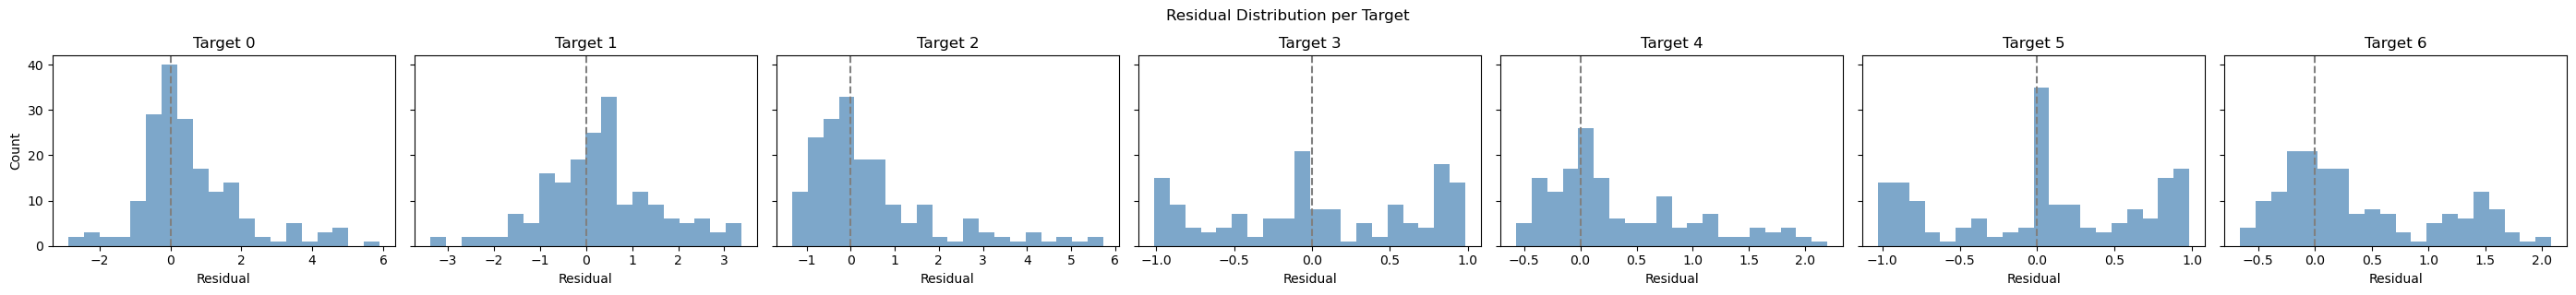

In [43]:
import matplotlib.pyplot as plt
import numpy as np

true_values = torch.stack([data[0].y for data in test_ds]).detach().cpu().numpy()
pred_values = torch.cat(trainer.predict(model, dataloaders=test_loader), dim=0).detach().cpu().numpy()

ignore_value = -10.0
n_targets = true_values.shape[1]
fig, axes = plt.subplots(1, n_targets, figsize=(4 * n_targets, 3), sharey=True)

for i in range(n_targets):
    mask = (true_values[:, i] != ignore_value) & (pred_values[:, i] != ignore_value)
    residuals = pred_values[mask, i] - true_values[mask, i]
    # residuals = np.clip(residuals, -10, 10)  # optional clipping

    print(f"[Target {i}] mean={residuals.mean():.3f}, std={residuals.std():.3f}, n={len(residuals)}")

    ax = axes[i]
    ax.hist(residuals, bins=20, alpha=0.7, color='steelblue')
    ax.set_title(f"Target {i}")
    ax.set_xlabel("Residual")
    if i == 0:
        ax.set_ylabel("Count")
    ax.axvline(0, color='gray', linestyle='--')

plt.tight_layout()
plt.suptitle("Residual Distribution per Target", y=1.05)
plt.show()


In [ ]:
values_dff = pred_values[:, 2] - true_values[:, 2] 
# find values higher than 8



indexes = np.where(values_dff > 2.5)[0]
print(indexes)

[  2  13  36  47 165 166]


In [ ]:
for i in indexes:
    print("Index: ", i)
    print("Molecules")
    print(test[i])
    print("Y values")
    print(test[i][0].y)
    print(model.target_normalizer.inverse_transform(test[i][0].y))

Index:  2
Molecules
[MoleculeData(f_atoms=[5, 137], f_bonds=[8, 151], a2b=[5], b2a=[8], a_scope=[1], b_scope=[1], y=[7], bonds=[4, 2], smiles='[H][N]N([H])[H]', b2revb=[8], name='rmg_rxn_2_r1h', comp_type='donor'), MoleculeData(f_atoms=[9, 137], f_bonds=[16, 151], a2b=[9], b2a=[16], a_scope=[1], b_scope=[1], y=[7], bonds=[8, 2], smiles='[H][N]C([H])([H])C([H])([H])[H]', b2revb=[16], name='rmg_rxn_2_r2h', comp_type='acceptor')]
Y values
tensor([-1.3164, -0.5695, -5.0387,  0.9736,  0.2282, -0.4615,  0.8871])
tensor([  1.1605,   1.3442, 146.2877,  76.8091, 332.5171])
Index:  13
Molecules
[MoleculeData(f_atoms=[6, 137], f_bonds=[10, 151], a2b=[6], b2a=[10], a_scope=[1], b_scope=[1], y=[7], bonds=[5, 2], smiles='[H]ON=C([H])[H]', b2revb=[10], name='rmg_rxn_15496_r1h', comp_type='donor'), MoleculeData(f_atoms=[9, 137], f_bonds=[16, 151], a2b=[9], b2a=[16], a_scope=[1], b_scope=[1], y=[7], bonds=[8, 2], smiles='[H]OC([H])([H])C([H])([H])[H]', b2revb=[16], name='rmg_rxn_15496_r2h', comp_type='

In [ ]:
pred_values

array([[ 0.23697221, -0.35358506,  0.04509876, ...,  0.07353568,
        -0.0117252 , -0.08884023],
       [ 0.17746954, -0.29733106,  0.04271146, ...,  0.05767586,
         0.00661283, -0.0928695 ],
       [ 0.24002448, -0.34488177,  0.04768741, ...,  0.06077601,
        -0.00169756, -0.0759846 ],
       ...,
       [ 0.05467891, -0.18175238,  0.02637218, ...,  0.0636536 ,
         0.01126916, -0.05522255],
       [ 0.14003433, -0.27141115,  0.03635652, ...,  0.06848601,
         0.01408806, -0.06112342],
       [ 0.17272869, -0.3201088 ,  0.04410845, ...,  0.0678249 ,
         0.0064241 , -0.06516512]], dtype=float32)

In [ ]:
import torch
import matplotlib.pyplot as plt

# preds and targets in degrees, shape (N,)
def plot_angular_error_heatmap(preds_deg, targets_deg, bins=60):
    preds_rad = torch.deg2rad(preds_deg)
    targets_rad = torch.deg2rad(targets_deg)

    angular_diff = 1 - torch.cos(preds_rad - targets_rad)  # in [0, 2]
    plt.figure(figsize=(6, 5))
    plt.hist(angular_diff.numpy(), bins=bins, color='orange', alpha=0.7)
    plt.title('Angular Error Distribution (1 - cos(pred - target))')
    plt.xlabel('Angular Error')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [ ]:
# Convert numpy arrays to tensors
pred_values_tensor = torch.tensor(pred_values)
true_values_tensor = torch.tensor(true_values)

pred_inv_values = model.target_normalizer.inverse_transform(pred_values_tensor)
true_inv_values = model.target_normalizer.inverse_transform(true_values_tensor)


In [ ]:
periodic_indices = [3, 4]
periodic_pred_angles = pred_inv_values[:, periodic_indices]
periodic_true_angles = true_inv_values[:, periodic_indices]

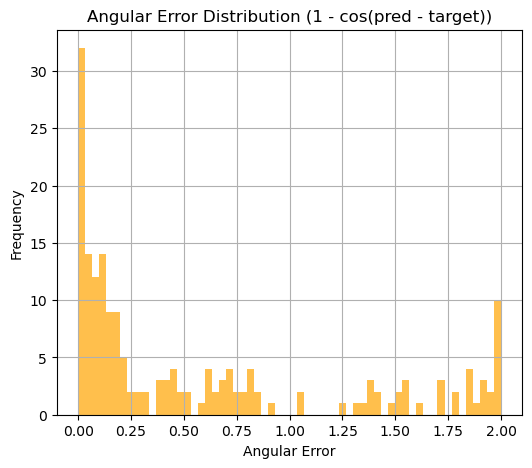

In [ ]:
plot_angular_error_heatmap(periodic_pred_angles[:, 0], periodic_true_angles[:, 0])  # For T3

In [ ]:
angular_diff = torch.remainder(periodic_pred_angles[:, 0] - periodic_true_angles[:, 0] + 180, 360) - 180  # in degrees
angular_mae = torch.abs(angular_diff)

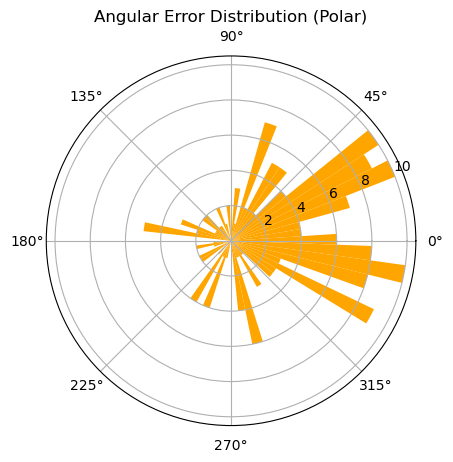

In [ ]:
ax = plt.subplot(111, polar=True)
theta = torch.deg2rad(angular_diff)  # assuming angular_diff in degrees
ax.hist(theta.numpy(), bins=60, color='orange')
ax.set_title("Angular Error Distribution (Polar)")
plt.show()


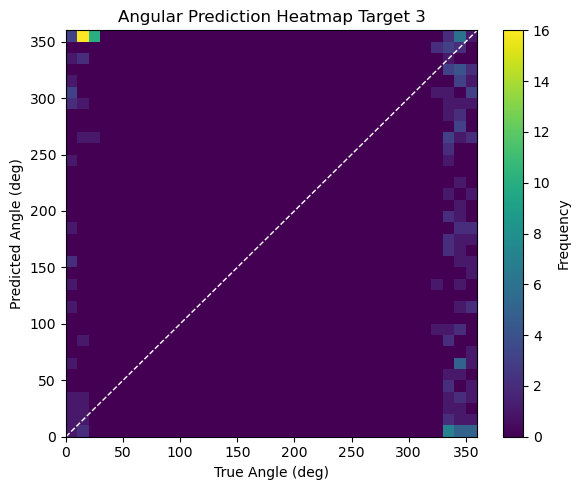

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 5))
pred_angles = periodic_pred_angles[:, 0] % 360
true_angles = periodic_true_angles[:, 0] % 360
plt.hist2d(
    pred_angles,
    true_angles,
    bins=(36, 36), 
    cmap='viridis',
    range=[[0, 360], [0, 360]]
)
plt.colorbar(label='Frequency')
plt.xlabel('True Angle (deg)')
plt.ylabel('Predicted Angle (deg)')
plt.plot([0, 360], [0, 360], color='white', linestyle='--', linewidth=1)

plt.title('Angular Prediction Heatmap Target 3')
plt.tight_layout()
plt.show()


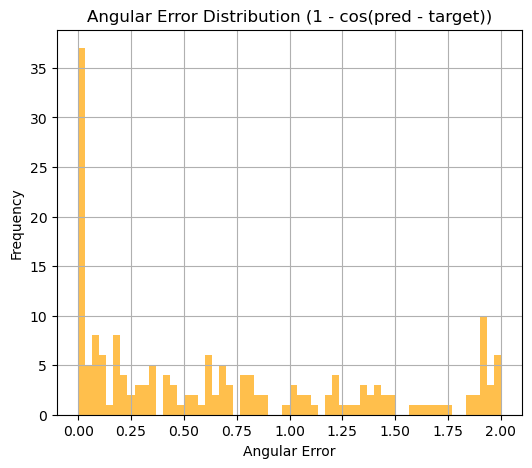

In [ ]:
plot_angular_error_heatmap(periodic_pred_angles[:, 1], periodic_true_angles[:, 1])  # For T4

In [ ]:
loss_t3 = positional_angular_loss(periodic_pred_angles[:, 0], periodic_true_angles[:, 0])

NameError: name 'positional_angular_loss' is not defined

In [ ]:
preds = trainer.predict(
    model,
    dataloaders=test_loader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
true_values = [data[0].y for data in test]

inv_tru = m_dataset.inverse_transform_y(inplace=False)# inplace=True means we modify the y values in the dataset)

In [ ]:
def plot_target_distribution(targets, target_idx, bins=40):
    raw = []
    for i in range(len(targets)):
        raw.append(targets[i][0][target_idx])
    log_safe = [] 
    for i in raw:
        if i > 0:
            log_safe.append(i)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    axes[0].hist(raw, bins=bins, density=True, alpha=0.7, color='skyblue')
    axes[0].set_title(f'Target {target_idx} (Raw)')
    axes[0].set_xlabel('Value')
    axes[0].set_ylabel('Density')

    axes[1].hist(np.log(log_safe), bins=bins, density=True, alpha=0.7, color='lightgreen')
    axes[1].set_title(f'Target {target_idx} (Log Transformed)')
    axes[1].set_xlabel('Log(Value)')
    axes[1].set_ylabel('Density')

    plt.tight_layout()
    plt.show()

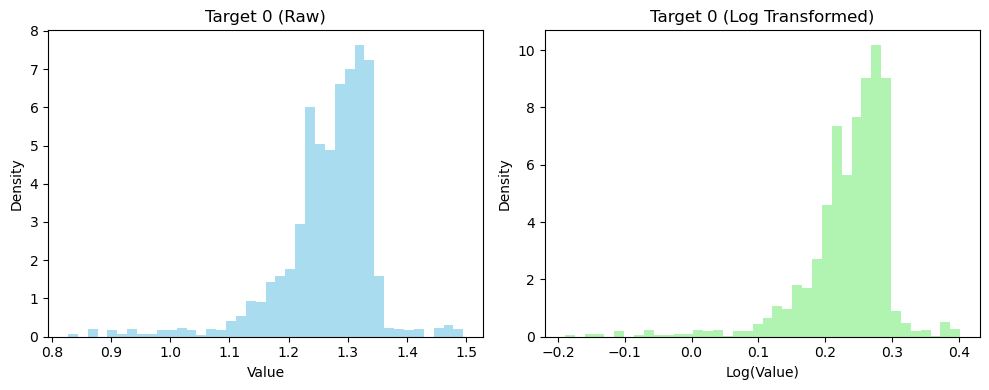

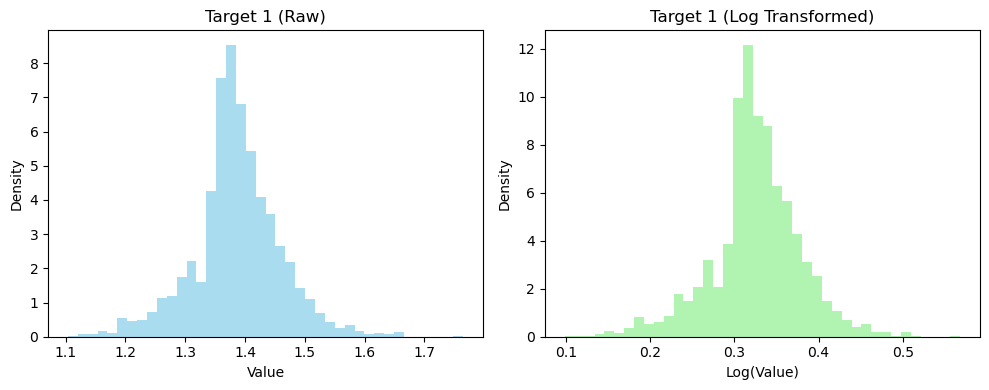

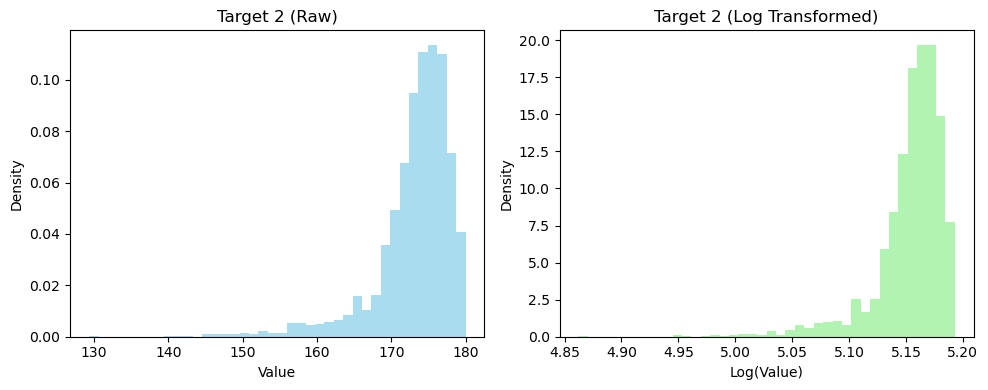

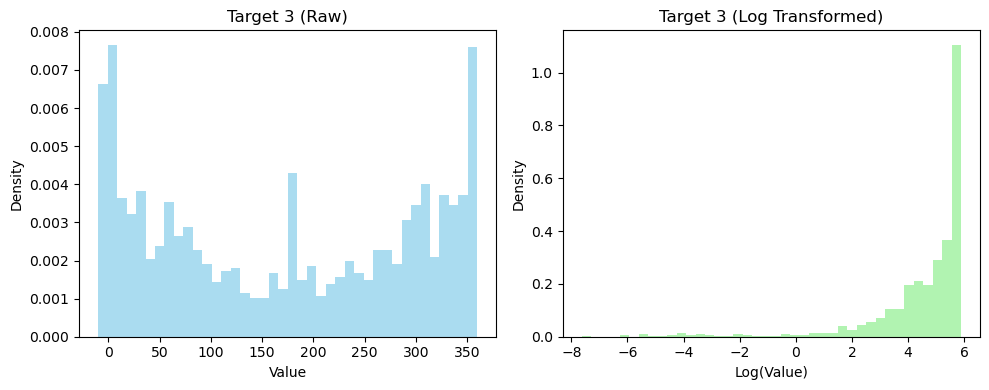

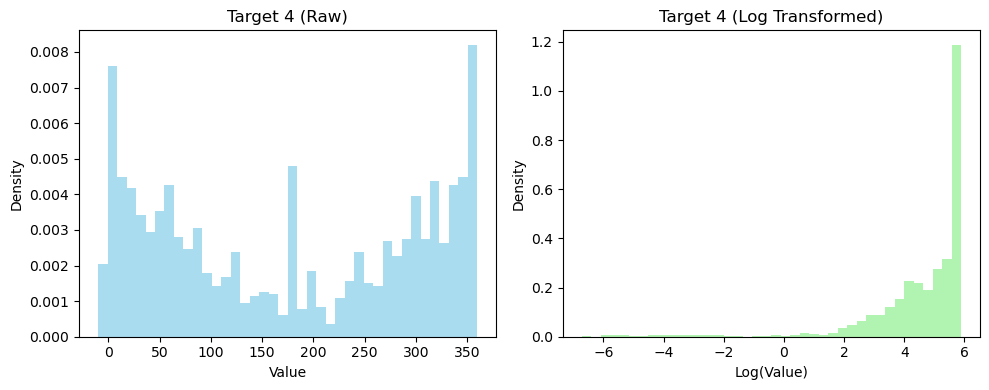

In [ ]:
for i in range(5):
    plot_target_distribution(inv_tru, i)

In [ ]:

t2 = []
for i in range(len(inv_tru)):
    t2.append(inv_tru[i][0][2])

In [ ]:
# turn the list of tensors into a tensor
t2 = torch.stack(t2) if isinstance(t2, list) else t2
t2.min().item() - 1e-6

129.3130330576172

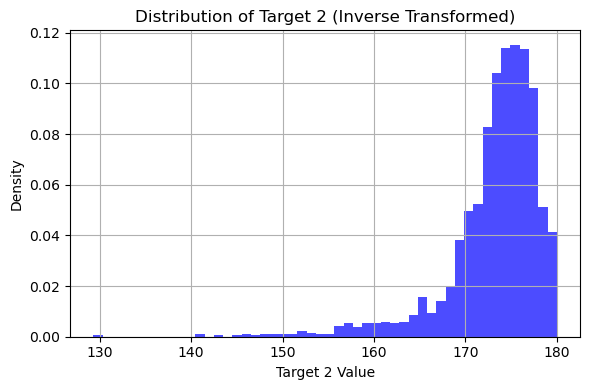

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(t2, bins=50, density=True, alpha=0.7, color='blue')
plt.title("Distribution of Target 2 (Inverse Transformed)")
plt.xlabel("Target 2 Value")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()

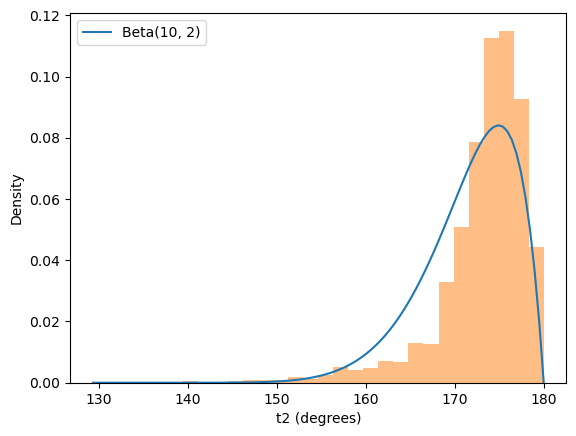

In [ ]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt

# Assume t2_raw is your array
a, b = 10, 2  # try more extreme skew
t2_raw = t2
x = np.linspace(t2_raw.min(), t2_raw.max(), 100)
scaled_x = (x - t2_raw.min()) / (t2_raw.max() - t2_raw.min())  # scale to [0, 1]
pdf = beta.pdf(scaled_x, a, b) / (t2_raw.max() - t2_raw.min())  # scale back to original interval

plt.plot(x, pdf, label=f"Beta({a}, {b})")
plt.hist(t2_raw, bins=30, density=True, alpha=0.5)
plt.legend()
plt.xlabel("t2 (degrees)")
plt.ylabel("Density")
plt.show()

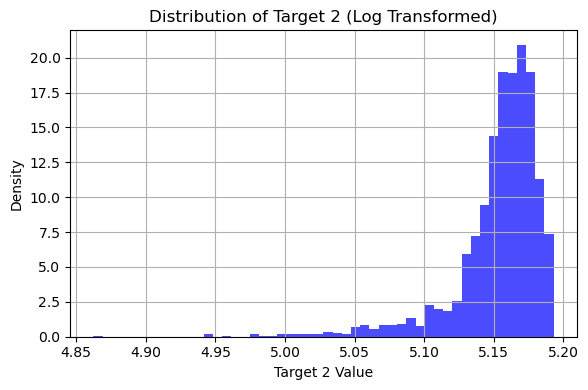

In [ ]:
target_2_log = [torch.log(x) for x in t2]
plt.figure(figsize=(6, 4))
plt.hist(target_2_log, bins=50, density=True, alpha=0.7, color='blue')
plt.title("Distribution of Target 2 (Log Transformed)")
plt.xlabel("Target 2 Value")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()

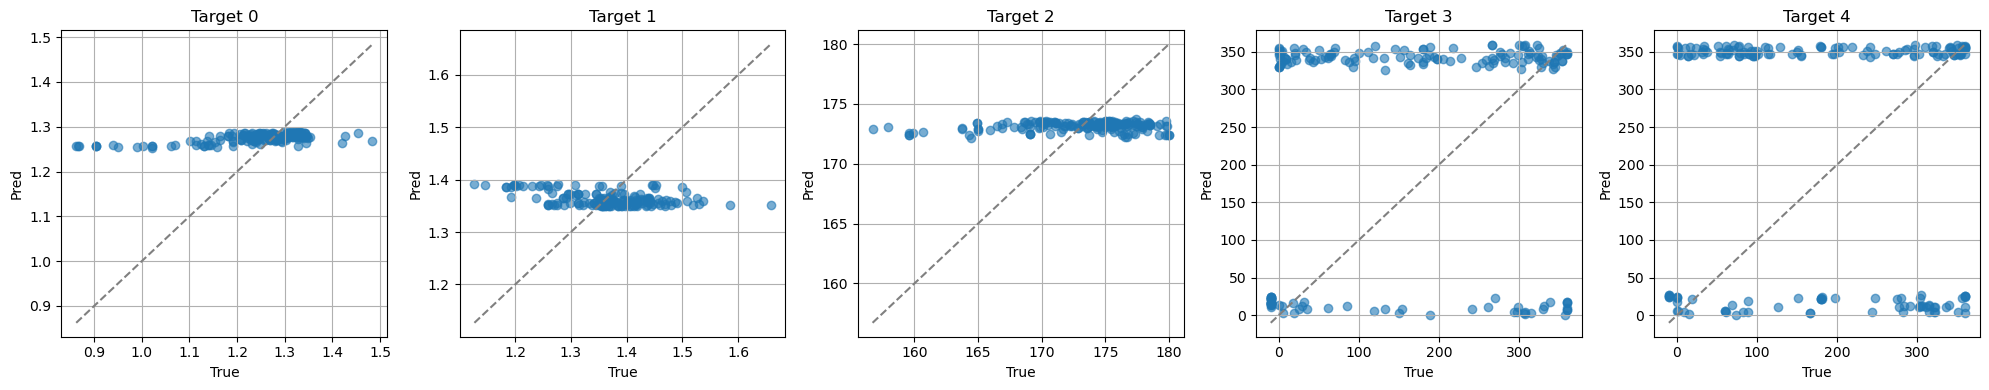

In [ ]:
import matplotlib.pyplot as plt
import torch

# Collect original targets and preds
targets = [d[0].y for d in test_loader.dataset]  # shape: (N, 7)
targets_tensor = torch.stack(targets)            # (N, 7)
preds_tensor = torch.cat(preds, dim=0)           # (N, 7)

# Inverse transform if normalizer exists
if hasattr(model, "target_normalizer") and model.target_normalizer is not None:
    device = preds_tensor.device
    preds_tensor = torch.stack([
        model.target_normalizer.inverse_transform(p.cpu()).to(device)
        for p in preds_tensor
    ])
    targets_tensor = torch.stack([
        model.target_normalizer.inverse_transform(t.cpu()).to(device)
        for t in targets_tensor
    ])

# Plot: one panel per target
n_targets = preds_tensor.shape[1]
fig, axs = plt.subplots(1, n_targets, figsize=(4 * n_targets, 4), squeeze=False)

for i in range(n_targets):
    ax = axs[0, i]
    y_true = targets_tensor[:, i].cpu()
    y_pred = preds_tensor[:, i].cpu()

    ax.scatter(y_true, y_pred, alpha=0.6)
    min_val = min(y_true.min().item(), y_pred.min().item())
    max_val = max(y_true.max().item(), y_pred.max().item())
    ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray')
    ax.set_xlabel("True")
    ax.set_ylabel("Pred")
    ax.set_title(f"Target {i}")
    ax.grid(True)

plt.tight_layout()
plt.show()


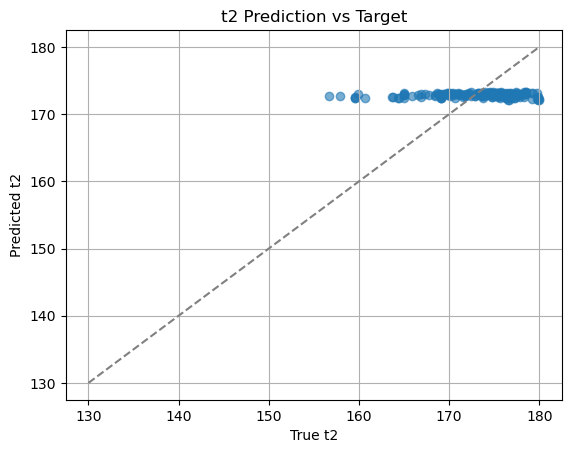

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(true_inv_values[:, 2].cpu(), pred_inv_values[:, 2].cpu(), alpha=0.6)
plt.xlabel("True t2")
plt.ylabel("Predicted t2")
plt.title("t2 Prediction vs Target")
plt.plot([130, 180], [130, 180], linestyle='--', color='gray')
plt.grid(True)
plt.show()

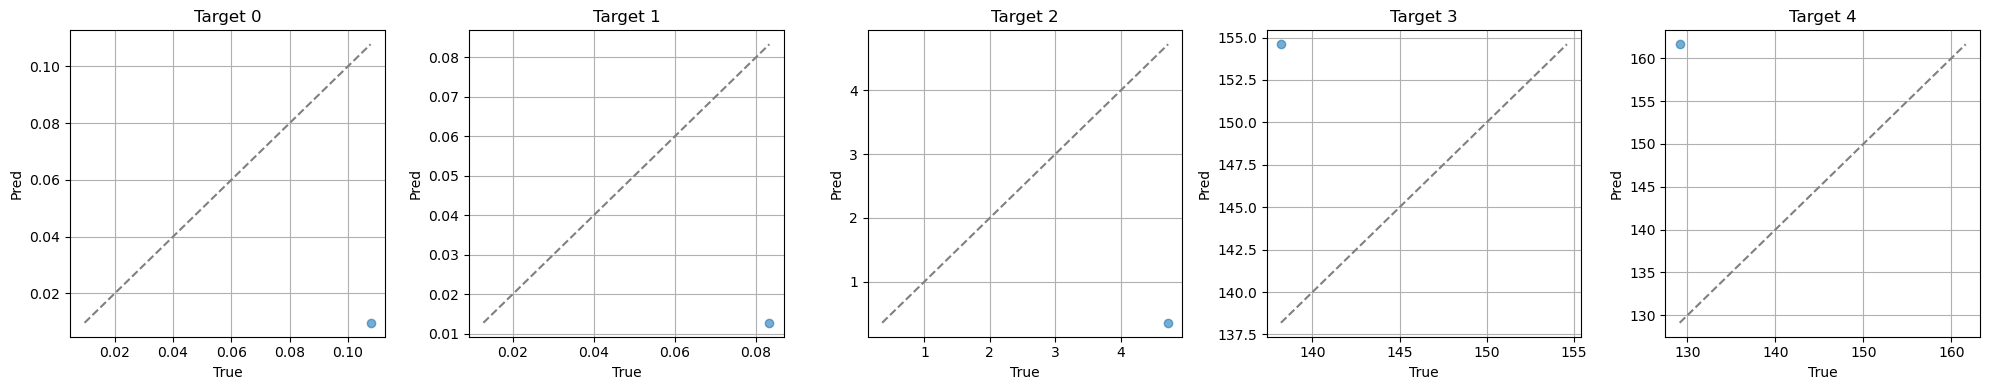

In [ ]:
# Plot the stddev of the predictions

import matplotlib.pyplot as plt
import numpy as np

n_targets = preds_tensor.shape[1]
fig, axs = plt.subplots(1, n_targets, figsize=(4 * n_targets, 4), squeeze=False)

for i in range(n_targets):
    ax = axs[0, i]
    y_pred = preds_tensor[:, i].std(dim=0).cpu()
    y_true = targets_tensor[:, i].std(dim=0).cpu()
    ax.scatter(y_true, y_pred, alpha=0.6)
    min_val = min(y_true.min().item(), y_pred.min().item())
    max_val = max(y_true.max().item(), y_pred.max().item())
    ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray')
    ax.set_xlabel("True")
    ax.set_ylabel("Pred")
    ax.set_title(f"Target {i}")
    ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print("True stddev for target 0: ", targets_tensor[:, 0].std(dim=0).cpu())
print("Pred stddev for target 0: ", preds_tensor[:, 0].std(dim=0).cpu())
print("True stddev for target 1: ", targets_tensor[:, 1].std(dim=0).cpu())
print("Pred stddev for target 1: ", preds_tensor[:, 1].std(dim=0).cpu())
print("True stddev for target 2: ", targets_tensor[:, 2].std(dim=0).cpu())
print("Pred stddev for target 2: ", preds_tensor[:, 2].std(dim=0).cpu())
print("True stddev for target 3: ", targets_tensor[:, 3].std(dim=0).cpu())
print("Pred stddev for target 3: ", preds_tensor[:, 3].std(dim=0).cpu())
print("True stddev for target 4: ", targets_tensor[:, 4].std(dim=0).cpu())
print("Pred stddev for target 4: ", preds_tensor[:, 4].std(dim=0).cpu())

True stddev for target 0:  tensor(0.1078)
Pred stddev for target 0:  tensor(0.0096)
True stddev for target 1:  tensor(0.0833)
Pred stddev for target 1:  tensor(0.0127)
True stddev for target 2:  tensor(4.7204)
Pred stddev for target 2:  tensor(0.3551)
True stddev for target 3:  tensor(138.1874)
Pred stddev for target 3:  tensor(154.6031)
True stddev for target 4:  tensor(129.1172)
Pred stddev for target 4:  tensor(161.6428)


In [ ]:
print("t2 Prediction spread vs Target spread (test set):")
print("Predicted σ (t2):", pred_inv_values[:, 2].std().item())
print("True σ (t2):", true_inv_values[:, 2].std().item())

t2 Prediction spread vs Target spread (test set):
Predicted σ (t2): 1.003586769104004
True σ (t2): 4.720402240753174


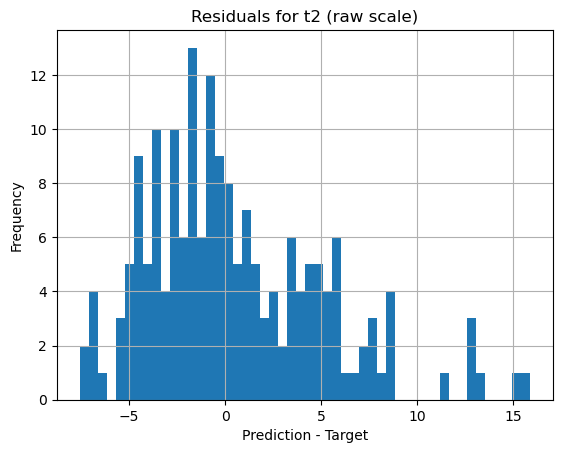

In [ ]:
residuals = pred_inv_values[:, 2] - true_inv_values[:, 2]
plt.hist(residuals.cpu().detach().numpy(), bins=50)
plt.title("Residuals for t2 (raw scale)")
plt.xlabel("Prediction - Target")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
errors = (pred_inv_values[:, 2] - true_inv_values[:, 2]).abs()
outliers = errors > 10
print(f"{outliers.sum().item()} / {len(errors)} samples have MAE > 10°")


7 / 182 samples have MAE > 10°


In [ ]:
from torch import nn
model.eval()
def enable_dropout(m):
    if isinstance(m, nn.Dropout):
        m.train()

model.apply(enable_dropout)

# Then predict multiple times and average
predictions = [model(batch).detach() for _ in range(10)]
mean_preds = torch.stack(predictions).mean(dim=0)


In [ ]:
mean_preds

tensor([[ 5.9229e-01,  5.5186e-02,  2.6356e-01,  8.0640e-02,  1.0481e+00,
         -1.9945e-02,  1.0222e+00],
        [ 4.6788e-01,  2.3853e-02,  2.4055e-01,  4.2399e-02,  1.0123e+00,
         -9.8078e-03,  1.0071e+00],
        [ 5.1353e-01,  3.7120e-02,  2.7172e-01, -3.4200e-02,  9.5536e-01,
          4.4670e-03,  9.8503e-01],
        [ 3.9213e-01,  5.3035e-02,  1.6753e-01,  1.4518e-01,  1.0096e+00,
          6.6854e-02,  9.4333e-01],
        [-1.7476e-01, -1.7962e-01, -6.3870e-02, -9.8910e-02,  1.0127e+00,
          6.6848e-02,  9.5814e-01],
        [ 4.6610e-01,  1.2497e-01,  1.7539e-01, -6.0551e-03,  9.8703e-01,
          5.7478e-02,  9.7416e-01],
        [ 3.5249e-01,  9.7549e-02,  1.7277e-01, -4.8868e-02,  1.0087e+00,
          6.2855e-02,  1.0028e+00],
        [ 5.6118e-01,  6.5400e-02,  3.1027e-01,  1.7127e-02,  1.0001e+00,
         -5.2701e-02,  9.8156e-01],
        [ 1.7233e-01,  1.2218e-02,  7.9347e-02,  5.2735e-02,  1.0086e+00,
          1.5322e-01,  9.7240e-01],
        [ 